# Project_13 - Regression (Mining)

**Project description**
<br>Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
<br>The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
<br>The model will help to optimize the production and eliminate unprofitable parameters.
<br>Parameters that are next to each other in terms of time are often similar.
<br>Some parameters are not available because they were measured and/or calculated much later.That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.
<br>You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data.
<br>For that, use our instructions.
<br>We need to predict two values:
<br>rougher concentrate recovery: rougher.output.recovery
<br>final concentrate recovery: final.output.recovery

**Project instructions**
<br>1. Prepare the data
<br>1.1. Open the files and look into the data.
<br>1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
<br>1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
<br>1.4. Perform data preprocessing.
<br>
<br>2. Analyze the data
<br>2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
<br>2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
<br>2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
<br>
<br>3. Build the model
<br>3.1. Write a function to calculate the final sMAPE value.
<br>3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

**1.1. Open the files and look into the data.**

In [2]:
#import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer

In [4]:
#import the datasets
df_train = pd.read_csv('datasets/project_05_dataset_train.csv')
df_test = pd.read_csv('datasets/project_05_dataset_test.csv')
df_full = pd.read_csv('datasets/project_05_dataset_full.csv')

In [3]:
# df_train.to_csv('~/work/project_datasets/project_05_dataset_train.csv', index=False, header=list(df_train.columns))
# df_test.to_csv('~/work/project_datasets/project_05_dataset_test.csv', index=False, header=list(df_test.columns))
# df_full.to_csv('~/work/project_datasets/project_05_dataset_full.csv', index=False, header=list(df_full.columns))

In [5]:
display(df_train.head(3))
df_train.info()
df_train['date'] = pd.to_datetime(df_train['date'])
#display(df_train.describe())
display(f'Dupliated Rows: {df_train.duplicated().sum()}')
display(f'Missing Values: {df_train.isna().sum().sum()}')
display(f'df Shape: {df_train.shape}')
display(f'df.dropna Shape: {df_train.dropna().shape}')

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


'Dupliated Rows: 0'

'Missing Values: 30320'

'df Shape: (16860, 87)'

'df.dropna Shape: (11017, 87)'

There are quite a lot of NaN values in df_train, and if these observations are dropped, we will be losing around 1/3 of the data.
<br>Since parameters that are next to each other in terms of time are often similar. I will be filling these NaN values using fillna(method='ffill'), but only on the non-ouput parameters(the parameters that are also present in the df_test dataset)

In [4]:
display(df_train[['rougher.output.recovery', 'final.output.recovery']].describe())

,rougher.output.recovery,final.output.recovery
count,14287.000000,15339.000000
mean,82.394201,67.213166
std,15.096808,11.960446
min,0.000000,0.000000
25%,79.818372,62.625685
50%,85.235997,67.644601
75%,90.131691,72.824595
max,100.000000,100.000000


display(df_train['rougher.output.recovery'].value_counts().head(3))
display(df_train['final.output.recovery'].value_counts().head(3))
display(len(df_train[(df_train['rougher.output.recovery']<=0) & (df_train['final.output.recovery']<=0)]))

In [5]:
display(df_train['rougher.output.recovery'].value_counts().head(3))
df_train = df_train.drop(index=df_train[df_train['rougher.output.recovery']==0].index)
display(df_train['rougher.output.recovery'].value_counts().head(3))

0.000000      320
83.406924      10
100.000000      6
Name: rougher.output.recovery, dtype: int64

83.406924     10
100.000000     6
91.792293      5
Name: rougher.output.recovery, dtype: int64

In [6]:
display(df_train['final.output.recovery'].value_counts().head(3))
df_train = df_train.drop(index=df_train[df_train['final.output.recovery']==0].index)
display(df_train['final.output.recovery'].value_counts().head(3))

100.000000    472
0.000000       88
75.962757       5
Name: final.output.recovery, dtype: int64

100.000000    472
75.962757       5
67.275195       5
Name: final.output.recovery, dtype: int64

In [7]:
display(df_train[['rougher.output.recovery', 'final.output.recovery']].describe())

,rougher.output.recovery,final.output.recovery
count,13910.000000,14954.000000
mean,84.308160,67.655653
std,8.573097,10.826117
min,1.075750,0.089846
25%,80.281148,62.838670
50%,85.480181,67.725644
75%,90.259143,72.870340
max,100.000000,100.000000


There are are 408 rows with either targets being 0. Since these may affect the final regression modeling, I will remove these.

In [8]:
display(df_test.head(3))
df_test.info()
df_test['date'] = pd.to_datetime(df_test['date'])
#display(df_test.describe())
display(f'Dupliated Rows: {df_test.duplicated().sum()}')
display(f'Missing Values: {df_test.isna().sum().sum()}')
display(f'df Shape: {df_test.shape}')
display(f'df.dropna Shape: {df_test.dropna().shape}')

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

'Dupliated Rows: 0'

'Missing Values: 2360'

'df Shape: (5856, 53)'

'df.dropna Shape: (5383, 53)'

There are also some NaN values in df_test, and if these observations are dropped, we will be losing around 1/10 of the data.
<br>I will fill these NaN values with the same 'ffill' method as I will use for df_train.

**1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. 
<br>Find the MAE between your calculations and the feature values. Provide findings.**

In [9]:
#define the recovery function
def recovery(C, F, T):
    rec = (C*(F-T)) / (F*(C-T)) * 100
    return rec

In [10]:
#define the different variables that will be used in the rougher recovery calculation (Used dropna() to remove NaN values)
df_train_0 = df_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].dropna()
C0 = df_train_0['rougher.output.concentrate_au']
F0 = df_train_0['rougher.input.feed_au']
T0 = df_train_0['rougher.output.tail_au']

pred_rough_recovery = recovery(C0, F0, T0)
target_rough_recovery = df_train_0['rougher.output.recovery']

#find the MAE between calculations and the feature values.
mae_score = MAE(target_rough_recovery, pred_rough_recovery)
print(mae_score)

9.515465338748842e-15


The MAE score between provided recovery value and calculated value is very small, which means the recovery feature was calculated correctly.
<br>Hence I will be using this function to fill in some of the NaN values in 'rougher.output.recovery'.

**1.3. Analyze the features not available in the test set. What are these parameters? What is their type?**

In [11]:
#analyze the features not available in the test set
train_columns = set(df_train.columns)
test_columns = set(df_test.columns)
column_diff = train_columns.difference(test_columns)
display(column_diff)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [12]:
display(df_train[column_diff].isna().sum())

rougher.output.tail_sol                               2220
final.output.tail_au                                    66
final.output.tail_sol                                  135
rougher.output.tail_ag                                2221
final.output.concentrate_ag                             72
rougher.output.concentrate_pb                           82
secondary_cleaner.output.tail_sol                     1942
primary_cleaner.output.tail_pb                          99
rougher.output.concentrate_ag                           82
rougher.calculation.au_pb_ratio                       1242
primary_cleaner.output.concentrate_ag                   82
final.output.concentrate_sol                           367
primary_cleaner.output.tail_au                          83
final.output.tail_ag                                    66
final.output.tail_pb                                   183
rougher.output.concentrate_sol                         152
secondary_cleaner.output.tail_pb                        

Features not available in the test set are either float type targets or params not measured and/or calculated much later.
<br>There are quite a few NaN values in the target columns, which I plan to address.

**1.4. Perform data preprocessing.**

In [13]:
#fill df_train parameter NaN values using 'ffill' method
display(df_train.isna().sum().sum())
df_train.loc[:, df_test.columns] = df_train.loc[:, df_test.columns].fillna(method='ffill')
display(df_train.isna().sum().sum())

29798

17337

In [14]:
#fill df_test NaN values using 'ffill' method
display(df_test.isna().sum().sum())
df_test = df_test.fillna(method='ffill')
display(df_test.isna().sum().sum())

2360

0

As stated earlier, since parameters that are next to each other in terms of time are often similar, I filled these NaN values using fillna(method='ffill').

0.00000    1213
0.01000     373
7.41075      22
Name: rougher.input.feed_au, dtype: int64

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.output.recovery,final.output.recovery
11498,0.0,0.00000,0.000000,0.000000,NaN,NaN
2030,0.0,0.00000,0.000000,0.000000,NaN,NaN
7520,0.0,0.00000,0.000000,0.000000,NaN,NaN
5936,0.0,0.00000,0.000000,0.000000,NaN,NaN
4948,0.0,0.00000,0.000000,0.000000,NaN,NaN
11924,0.0,5.90538,20.679983,28.308476,NaN,NaN
7582,0.0,0.00000,0.000000,0.000000,NaN,NaN
1823,0.0,0.00000,0.000000,0.000000,NaN,NaN
11614,0.0,0.00000,26.139368,40.243870,NaN,NaN
11570,0.0,0.00000,0.000000,0.000000,NaN,NaN


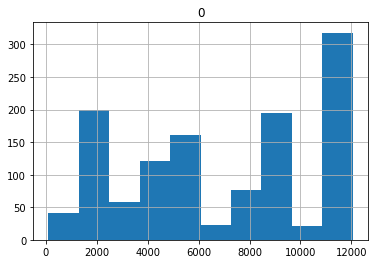

In [15]:
#checking and removing 0s in 'rougher.input.feed_au' column
display(df_train['rougher.input.feed_au'].value_counts().head(3))
output_col = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'rougher.output.recovery', 'final.output.recovery']
display(df_train[df_train['rougher.input.feed_au']==0][output_col].sample(10))
zero_value_index = df_train[df_train['rougher.input.feed_au']==0].index
pd.DataFrame(zero_value_index).hist()
plt.show()

In [16]:
df_train = df_train.drop(index=zero_value_index)
display(df_train['rougher.input.feed_au'].value_counts().head(3))

0.010000    373
7.410750     22
7.556612     10
Name: rougher.input.feed_au, dtype: int64

There were 1213 entries of 0 values in df_train's 'rougher.input.feed_au' column, which made most of the subsequent features 0 or NaN.
<br>Hence I removed these rows from the 'rougher.input.feed_au' column.

In [17]:
#checking and removing 0s in 'rougher.output.concentrate_au' column (input variable for final recovery function)
display(df_train['rougher.output.concentrate_au'].value_counts().head(3))
df_train = df_train.drop(index=df_train[df_train['rougher.output.concentrate_au']==0].index)
display(df_train['rougher.output.concentrate_au'].value_counts().head(3))

0.010000     439
0.000000      48
15.715523     11
Name: rougher.output.concentrate_au, dtype: int64

0.010000     439
13.791368     11
15.715523     11
Name: rougher.output.concentrate_au, dtype: int64

In [18]:
#define the different variables that will be used in the final recovery calculation (Used dropna() to remove NaN values)
df_train_1 = df_train[['rougher.output.concentrate_au', 'final.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery']].dropna()
C1 = df_train_1['final.output.concentrate_au']
F1 = df_train_1['rougher.output.concentrate_au']
T1 = df_train_1['final.output.tail_au']

pred_final_recovery = recovery(C1, F1, T1)
target_final_recovery = df_train_1['final.output.recovery']

#find the MAE between calculations and the feature values.
mae_score = MAE(target_final_recovery, pred_final_recovery)
print(mae_score)

179.16844828930394


In [19]:
display(pred_final_recovery.describe())
display(target_final_recovery.describe())
display(df_train['final.output.recovery'].isna().sum().sum())

count    14936.000000
mean       -64.236331
std       2388.373899
min     -84924.557091
25%         90.098366
50%         91.752935
75%         93.110003
max        246.102896
dtype: float64

count    14936.000000
mean        67.651708
std         10.813652
min          0.089846
25%         62.840367
50%         67.724246
75%         72.865356
max        100.000000
Name: final.output.recovery, dtype: float64

255

I was not able to get a small value for the MAE score between the provided 'final.output.recovery' value and the calculated value, which means I can't use the recovery function to fill in some of the NaN values.
<br>Hence the 255 NaN values in 'final.output.recovery' will probably need to be dropped for the regression modeling.

In [20]:
display(df_test['rougher.input.feed_au'].value_counts().head(3))
df_test = df_test.drop(index=df_test[df_test['rougher.input.feed_au']==0].index)
display(df_test['rougher.input.feed_au'].value_counts().head(3))

0.000000     371
10.435145     14
7.495525       6
Name: rougher.input.feed_au, dtype: int64

10.435145    14
7.495525      6
9.904077      2
Name: rougher.input.feed_au, dtype: int64

There were 371 entries of 0 values in df_test's 'rougher.input.feed_au' column, which made all the subsequent features 0 or NaN.
<br>Hence I removed these rows from the 'rougher.input.feed_au' column.

**2. Analyze the data
<br>2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.**

In [21]:
#create metal concentration dataframes
df_train_au = df_train[[col for col in df_train.columns if 'au' in col]]
df_train_au_ps = df_train_au[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].dropna()

df_train_ag = df_train[[col for col in df_train.columns if 'ag' in col]]
df_train_ag_ps = df_train_ag[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].dropna()

df_train_pb = df_train[[col for col in df_train.columns if 'pb' in col]]
df_train_pb_ps = df_train_pb[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].dropna()

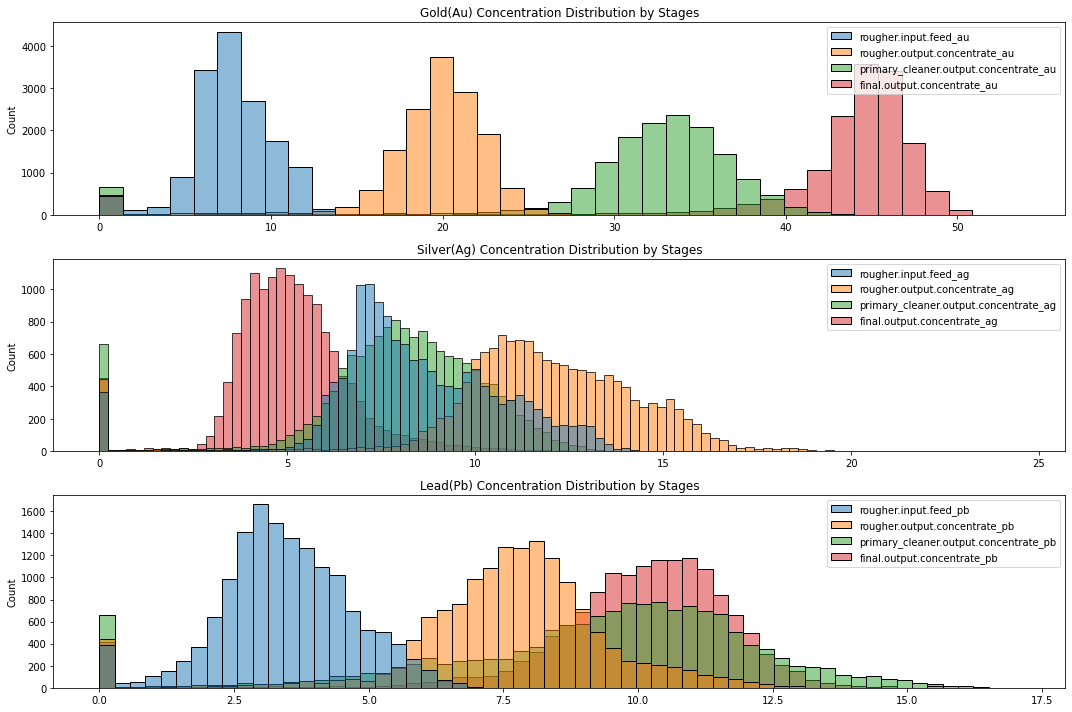

In [22]:
#plot and compare metal concentration distribution in different stages
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
sns.histplot(data=df_train_au_ps, alpha=0.5, legend=True, ax=axes[0])
axes[0].set_title('Gold(Au) Concentration Distribution by Stages')

sns.histplot(data=df_train_ag_ps, alpha=0.5, legend=True, ax=axes[1])
axes[1].set_title('Silver(Ag) Concentration Distribution by Stages')

sns.histplot(data=df_train_pb_ps, alpha=0.5, legend=True, ax=axes[2])
axes[2].set_title('Lead(Pb) Concentration Distribution by Stages')

plt.tight_layout()
plt.show()

Judging from the charts, while the concentrations of Au and Pb were steadily increasing with each purification stage, the concentration of Ag fluctuated quite a lot during the purification stages and ultimately ended up lower than the rougher input feed on average.

**2.2. Compare the feed particle size distributions in the training set and in the test set.
<br>If the distributions vary significantly, the model evaluation will be incorrect.**

In [23]:
#create feed_size dataframes
df_train_fs = df_train['rougher.input.feed_size']
df_test_fs = df_test['rougher.input.feed_size']

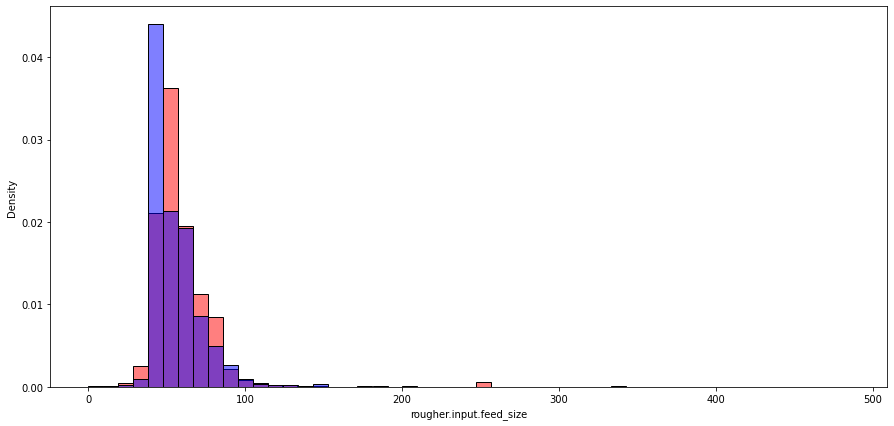

In [24]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df_train_fs, stat='density', color='r', alpha=0.5, bins=50)
sns.histplot(data=df_test_fs, stat='density', color='b', alpha=0.5, bins=50)
plt.show()

The feed particle size distributions in the training set and in the test set are quite similar. We can proceed with the model evaluation.

**2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate.
<br>Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? <br>Describe the findings and eliminate anomalies.**

In [25]:
#create new columns for the total concentrations
df_au = df_train_au[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].sum(axis=1)
df_ag = df_train_ag[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].sum(axis=1)
df_pb = df_train_pb[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].sum(axis=1)

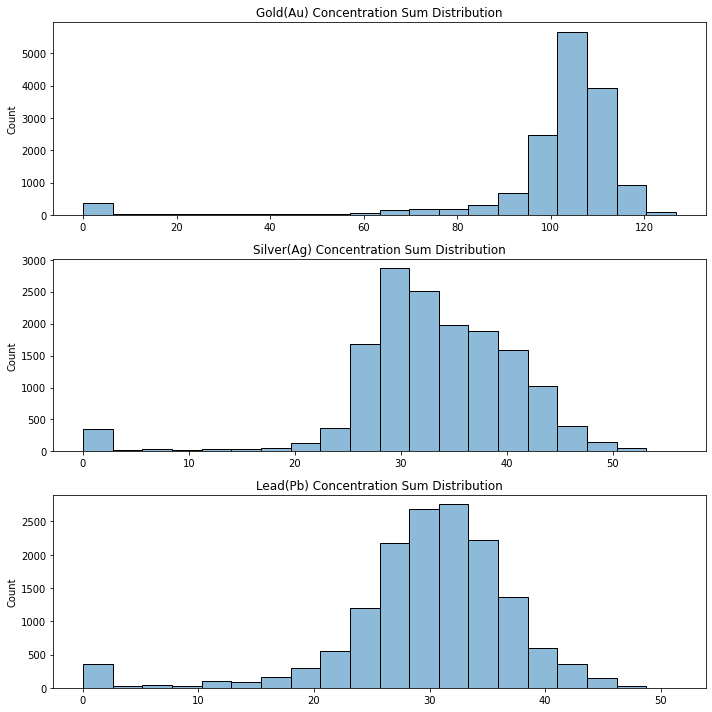

In [26]:
#plot and compare the metal concentration distributions
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.histplot(data=df_au, alpha=0.5, legend=True, ax=axes[0], bins=20)
axes[0].set_title('Gold(Au) Concentration Sum Distribution')

sns.histplot(data=df_ag, alpha=0.5, legend=True, ax=axes[1], bins=20)
axes[1].set_title('Silver(Ag) Concentration Sum Distribution')

sns.histplot(data=df_pb, alpha=0.5, legend=True, ax=axes[2], bins=20)
axes[2].set_title('Lead(Pb) Concentration Sum Distribution')

plt.tight_layout()
plt.show()

In [27]:
display(len(df_train_au[df_au==0]))
display(len(df_train_au[df_au<3]))
display(len(df_train_ag[df_ag==0]))
display(len(df_train_ag[df_ag<3]))
display(len(df_train_pb[df_pb==0]))
display(len(df_train_pb[df_pb<3]))

0

353

0

355

0

368

While there seems to be some total_concentrations that are close to zero.
<br>The count for gold is quite small compared to the overall dataset, so I think these could be ignored.

**3. Build the model
<br>3.1. Write a function to calculate the final sMAPE value.**

In [28]:
#define smape and final_smape functions
def smape(target, prediction): 
    return (1/len(target)) * sum(abs(prediction - target) / ((abs(target) + abs(prediction)) / 2) * 100)

def final_smape(target, prediction):
    rougher = smape(target[:, 0], prediction[:, 0])
    final = smape(target[:, 1], prediction[:, 1])
    return rougher * 0.25 + final * 0.75

smape_score = make_scorer(final_smape, greater_is_better=False)

**3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.**

In [29]:
df_train_final = df_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
X_train = df_train_final.loc[:, df_test.columns].drop('date', axis=1)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train)
y_train = df_train_final[['rougher.output.recovery', 'final.output.recovery']].values

In [30]:
#train linear regression model and evaluate using cross validation 
mo_lr = LinearRegression().fit(X_train_scaled, y_train)
scores_lr = cross_val_score(mo_lr, X_train_scaled, y_train, cv=5, scoring=smape_score)
print("Mean sMAPE:", np.nanmean(scores_lr))

Mean sMAPE: -10.079493531735503


In [31]:
#train random forest regression model
rfr_params = {'max_depth': [3, 5], 'n_estimators': [50, 100, 150]}
mo_rfr = RandomForestRegressor(random_state=42)
rfr_cv_score_au = GridSearchCV(mo_rfr, param_grid=rfr_params, scoring=smape_score, cv=5)
rfr_cv_score_au.fit(X_train_scaled, y_train)
display(f'RandomForest Best Params: {rfr_cv_score_au.best_params_}')
display(f'RandomForest Best Score: {rfr_cv_score_au.best_score_}')
mo_rfr_model = rfr_cv_score_au.best_estimator_

"RandomForest Best Params: {'max_depth': 3, 'n_estimators': 150}"

'RandomForest Best Score: -8.71440567333595'

In [32]:
#train decision tree regression model
dtr_params = {'max_depth': [3, 5, 7]}
mo_dtr = DecisionTreeRegressor(random_state=42)
dtr_cv_score_au = GridSearchCV(mo_dtr, param_grid=dtr_params, scoring=smape_score, cv=5)
dtr_cv_score_au.fit(X_train_scaled, y_train)
display(f'DecisionTree Best Params: {dtr_cv_score_au.best_params_}')
display(f'DecisionTree Best Score: {dtr_cv_score_au.best_score_}')
mo_dtr_model = dtr_cv_score_au.best_estimator_

"DecisionTree Best Params: {'max_depth': 3}"

'DecisionTree Best Score: -9.174397610257927'

In [48]:
#make predictions on the test set
X_test = df_test.drop('date', axis=1)
X_test_scaled = scaler.transform(X_test)
final_pred_au_lr = mo_lr.predict(X_test_scaled)
final_pred_au_rfr = mo_rfr_model.predict(X_test_scaled)
final_pred_au_dtr = mo_dtr_model.predict(X_test_scaled)

display(final_pred_au_rfr)

array([[86.16137285, 70.61789685],
       [85.91013318, 70.31906182],
       [85.91013318, 70.31906182],
       ...,
       [92.16789707, 74.48319534],
       [92.16789707, 74.48319534],
       [92.16789707, 74.48319534]])

In [49]:
#check if all the models made predictions in reasonable ranges
df_pred_lr = pd.DataFrame(final_pred_au_lr, columns=[['rougher.output.recovery', 'final.output.recovery']])
df_pred_rfr = pd.DataFrame(final_pred_au_rfr, columns=[['rougher.output.recovery', 'final.output.recovery']])
df_pred_dtr = pd.DataFrame(final_pred_au_dtr, columns=[['rougher.output.recovery', 'final.output.recovery']])
print(df_pred_lr.describe(), '\n')
print(df_pred_rfr.describe(), '\n')
print(df_pred_dtr.describe())

df_test_full = pd.concat([df_test, df_pred_rfr], axis=1, ignore_index=True)
display(df_test_full.shape)

      rougher.output.recovery final.output.recovery
count             5485.000000           5485.000000
mean                85.061302             68.744747
std                  5.542986              6.532456
min                 41.670289             13.217417
25%                 81.809055             65.434142
50%                 84.802316             69.339113
75%                 88.494349             72.754684
max                109.209629             99.145031 

      rougher.output.recovery final.output.recovery
count             5485.000000           5485.000000
mean                85.339195             68.032963
std                  4.517877              4.018983
min                 74.020583             55.947479
25%                 82.251940             65.146182
50%                 82.588708             66.251334
75%                 89.550601             71.688963
max                 92.167897             74.483195 

      rougher.output.recovery final.output.recovery
count   

(5847, 55)

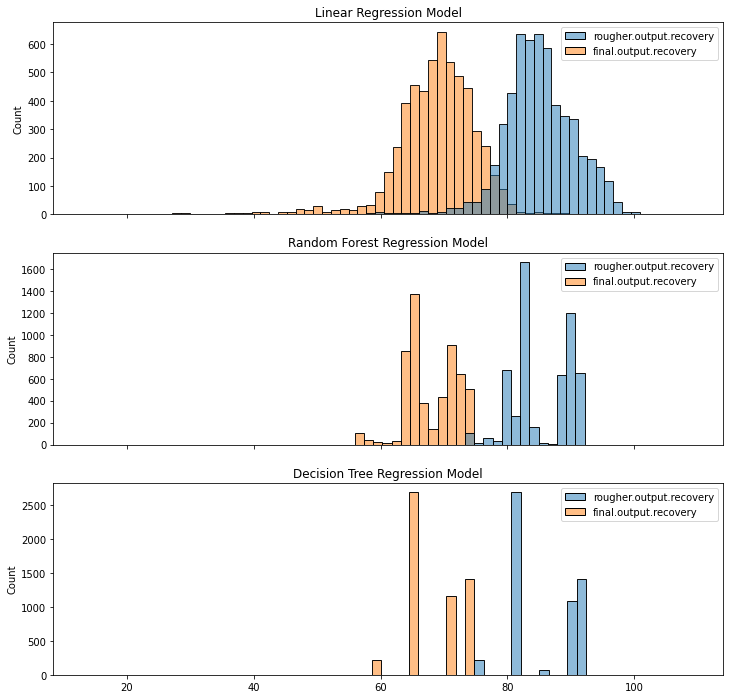

In [55]:
#visualize the prediction outputs
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
sns.histplot(data=df_pred_lr, ax=axes[0], alpha=0.5)
axes[0].set_title("Linear Regression Model")

sns.histplot(data=df_pred_rfr, ax=axes[1], alpha=0.5)
axes[1].set_title("Random Forest Regression Model")

sns.histplot(data=df_pred_dtr, ax=axes[2], alpha=0.5)
axes[2].set_title("Decision Tree Regression Model")

plt.subplots_adjust(hspace=0.3)
plt.show()

-After revisiting the data preprocessing steps, I realized that using the recovery function to fill in the NaN values in the 'rougher.output.recovery' column resulted in a lot of extreme values/outliers being added to the dataset.
<br>-Hence, I removed that step from preprocessing and refitted the 3 regressor models to the corrected dataset.
<br>-This time, the RandomForestRegressor model was the best performing, and I didn't get the constant prediction issue.
<br>-As for the prediction distribution of the DecisionTreeRegressor model, it's still very concentrated in a small number of narrow ranges, which I couldn't figure out why. I'm guessing it may be due to the model trying to optimize based on the smape_score, which resulted in the model choosing a smaller max_depth leading to underfitting.

## Conclusions

Upon fitting three distinct models, using the SMAPE score as the metric, the RandomForestRegressor showed the most favorable performance.